Select the T1CE MRI file
Select the T2 MRI file
Select the FLAIR MRI file
Loading MRI images...
Combining and cropping MRI images...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 844ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 859ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 919ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 858ms/step


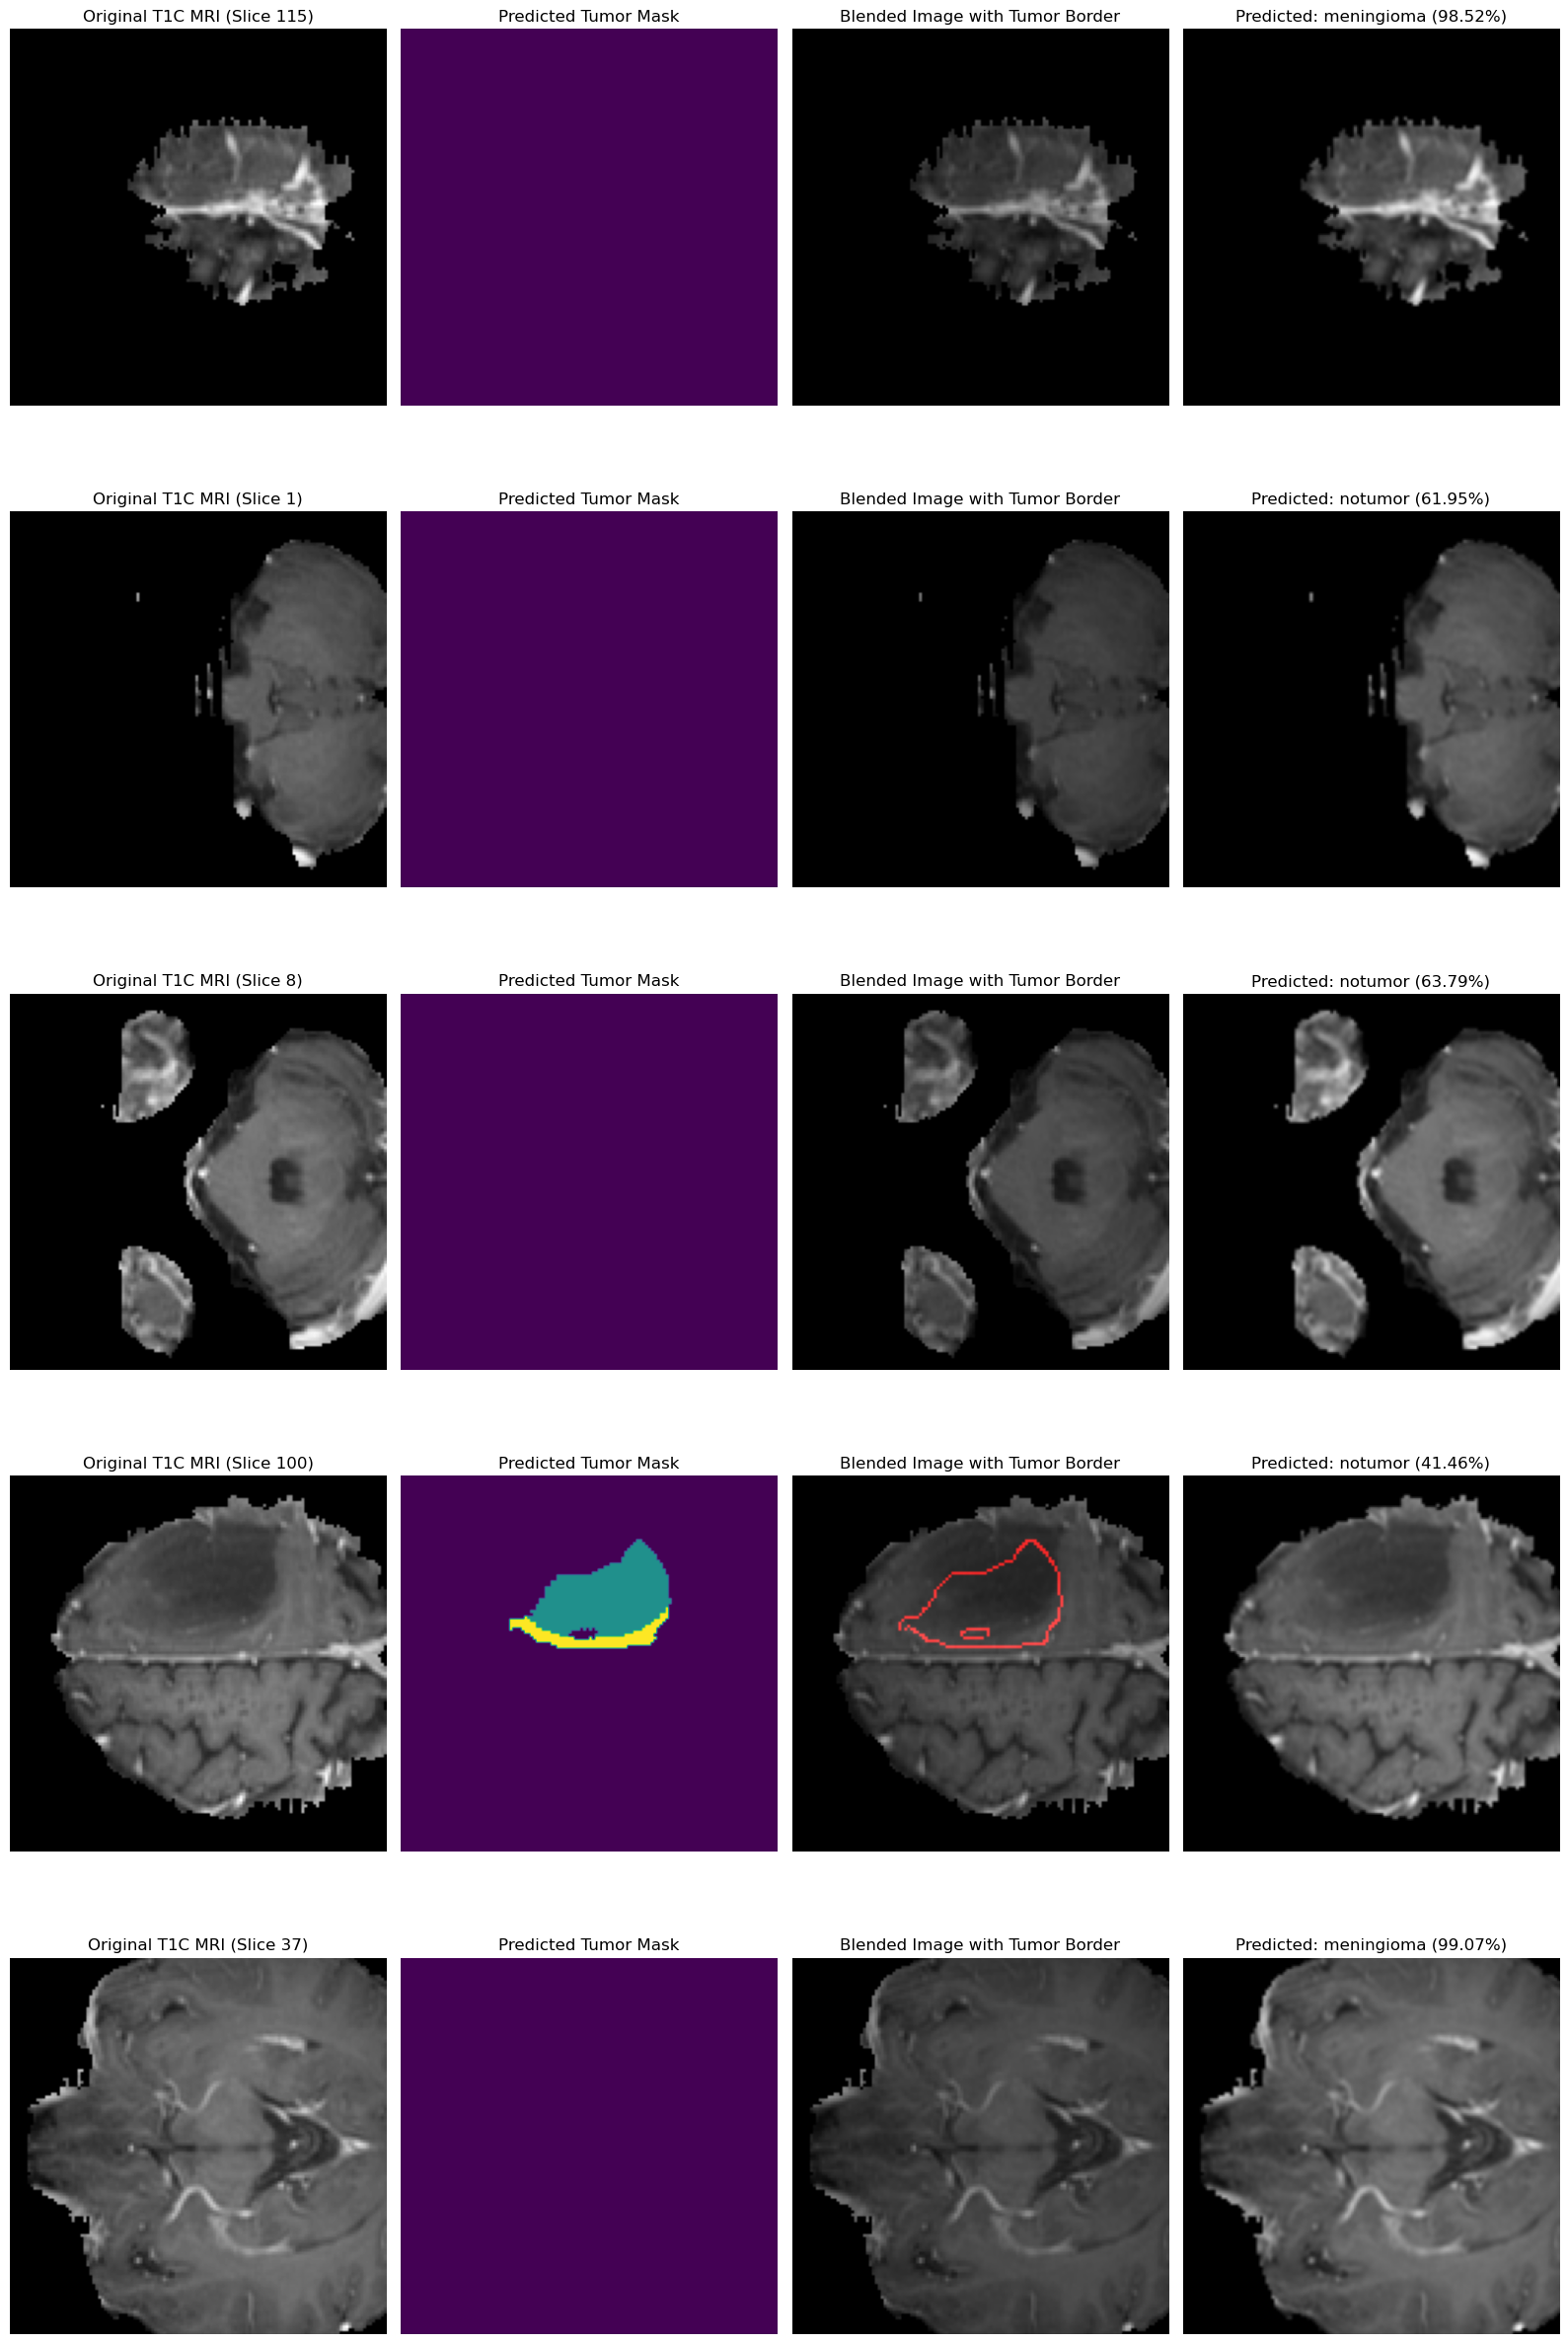

In [14]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import filedialog
import nibabel as nib
from keras.models import load_model
import random

def upload_mri():
    root = tk.Tk()
    root.withdraw()
    
    print("Select the T1CE MRI file")
    t1ce_path = filedialog.askopenfilename(title="Select T1CE MRI", filetypes=[("NIfTI files", "*.nii;*.nii.gz")])
    print("Select the T2 MRI file")
    t2_path = filedialog.askopenfilename(title="Select T2 MRI", filetypes=[("NIfTI files", "*.nii;*.nii.gz")])
    print("Select the FLAIR MRI file")
    flair_path = filedialog.askopenfilename(title="Select FLAIR MRI", filetypes=[("NIfTI files", "*.nii;*.nii.gz")])
    
    return t1ce_path, t2_path, flair_path

def load_mri_image(path):
    img = nib.load(path)
    data = img.get_fdata()
    return data

def combine_and_crop_mri(t1ce, t2, flair):
    combined_x = np.stack([flair, t1ce, t2], axis=3)
    combined_x = combined_x[56:184, 56:184, 13:141]
    return combined_x

def process_and_predict():
    t1ce_path, t2_path, flair_path = upload_mri()
    
    print("Loading MRI images...")
    t1ce = load_mri_image(t1ce_path)
    t2 = load_mri_image(t2_path)
    flair = load_mri_image(flair_path)
    
    print("Combining and cropping MRI images...")
    combined_x = combine_and_crop_mri(t1ce, t2, flair)
    
    # Select 5 random slices for visualization
    random_slice_idxs = random.sample(range(combined_x.shape[2]), 5)
    
    class_model_path = r"C:\\Users\\BharathKumar\\Desktop\\Tumour_Classification\\tumor_classification.keras"
    class_model = load_model(class_model_path)

    seg_model_path = r"C:\\Users\\BharathKumar\\Desktop\\Final_Tumor_seg_Project\\brats_30_epochs.hdf5"
    seg_model = load_model(seg_model_path, compile=False)
    
    class_labels = ['glioma', 'healthy', 'meningioma', 'notumor', 'pituitary']
    
    # Prepare subplots
    fig, ax = plt.subplots(5, 4, figsize=(16, 25))  # 5 rows, 4 columns

    for i, random_slice_idx in enumerate(random_slice_idxs):
        # Process the slice for classification and segmentation
        t1c_slice = combined_x[:, :, random_slice_idx, 1]
        t1c_slice_norm = (t1c_slice - np.min(t1c_slice)) / (np.max(t1c_slice) - np.min(t1c_slice))
        t1c_slice_uint8 = (t1c_slice_norm * 255).astype(np.uint8)
        
        # Classification
        t1c_img_rgb = np.stack((t1c_slice_uint8,) * 3, axis=-1)
        img_resized = cv2.resize(t1c_img_rgb, (256, 256))
        img_array = np.expand_dims(img_resized, axis=0) / 255.0
        
        prediction = class_model.predict(img_array)
        predicted_class = class_labels[np.argmax(prediction)]
        confidence = np.max(prediction) * 100
        
        # Segmentation
        mri_input = np.expand_dims(combined_x, axis=0)
        seg_prediction = seg_model.predict(mri_input)
        seg_prediction_argmax = np.argmax(seg_prediction, axis=4)[0, :, :, :]
        
        test_img_rgb = cv2.cvtColor(t1c_slice_uint8, cv2.COLOR_GRAY2RGB)
        pred_mask_uint8 = np.uint8(np.clip(seg_prediction_argmax[:, :, random_slice_idx], 0, 1) * 255)
        mask_edges = cv2.Canny(pred_mask_uint8, 100, 200)
        mask_edges_colored = np.zeros_like(test_img_rgb)
        mask_edges_colored[mask_edges > 0] = [255, 0, 0]
        blended_with_edges = cv2.addWeighted(test_img_rgb, 0.7, mask_edges_colored, 0.8, 0)
        
        # Display images for each random slice
        ax[i, 0].imshow(t1c_slice, cmap='gray')
        ax[i, 0].set_title(f'Original T1C MRI (Slice {random_slice_idx})')
        ax[i, 0].axis('off')
        
        ax[i, 1].imshow(seg_prediction_argmax[:, :, random_slice_idx])
        ax[i, 1].set_title('Predicted Tumor Mask')
        ax[i, 1].axis('off')
        
        ax[i, 2].imshow(blended_with_edges)
        ax[i, 2].set_title('Blended Image with Tumor Border')
        ax[i, 2].axis('off')
        
        ax[i, 3].imshow(img_resized)
        ax[i, 3].set_title(f"Predicted: {predicted_class} ({confidence:.2f}%)")
        ax[i, 3].axis('off')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    process_and_predict()
